<a href="https://colab.research.google.com/github/chitrung218/nucleo-l4r5zi-sine-cube-ai/blob/test_LSTM/Train/Sine_TinyML_Tensorflow_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Deep learning networks learn to model patterns in underlying data. Here, we're going to train a network to model data generated by a sine function. This will result in a model that can take a value, x, and predict its sine, y.

The model created in this notebook is used in the hello_world example for TensorFlow Lite for MicroControllers.

In [ ]:
# Define paths to model files
import os
MODELS_DIR = 'models/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
MODEL_H5 = MODELS_DIR + "model.h5"
MODEL_TF = MODELS_DIR + 'model'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'model_no_quant.tflite'
MODEL_TFLITE = MODELS_DIR + 'model.tflite'
MODEL_TFLITE_MICRO = MODELS_DIR + 'model.cc'

#Setup Environment


In [ ]:
! pip install tensorflow==2.4.1

## Import Dependencies

In [ ]:
# TensorFlow is an open source machine learning library
import tensorflow as tf

# Keras is TensorFlow's high-level API for deep learning
from tensorflow import keras
# Numpy is a math library
import numpy as np
# Pandas is a data manipulation library 
import pandas as pd
# Matplotlib is a graphing library
import matplotlib.pyplot as plt
# Math is Python's math library
import math

# Set seed for experiment reproducibility
seed = 1
np.random.seed(seed)
tf.random.set_seed(seed)

#Dataset

## 1. Generate Data
The code in the following cell will generate a set of random x values, calculate their sine values, and display them on a graph.

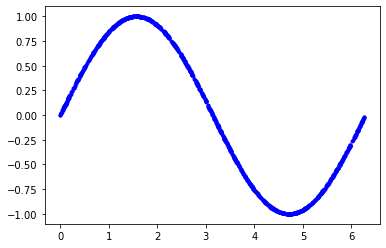

In [ ]:
# Number of sample datapoints
SAMPLES = 1000

# Generate a uniformly distributed set of random numbers in the range from
# 0 to 2π, which covers a complete sine wave oscillation
x_values = np.random.uniform(
    low=0, high=2*math.pi, size=SAMPLES).astype(np.float32)

# Shuffle the values to guarantee they're not in order
np.random.shuffle(x_values)

# Calculate the corresponding sine values
y_values = np.sin(x_values).astype(np.float32)

# Plot our data. The 'b.' argument tells the library to print blue dots.
plt.plot(x_values, y_values, 'b.')
plt.show()

## 2. Add Noise
Since it was generated directly by the sine function, our data fits a nice, smooth curve.

However, machine learning models are good at extracting underlying meaning from messy, real world data. To demonstrate this, we can add some noise to our data to approximate something more life-like.

In the following cell, we'll add some random noise to each value, then draw a new graph:

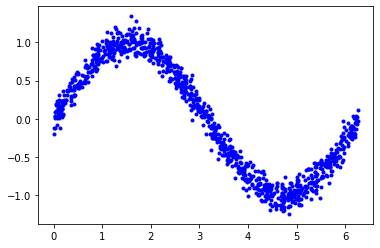

In [ ]:
# Add a small random number to each y value
y_values += 0.1 * np.random.randn(*y_values.shape)

# Plot our data
plt.plot(x_values, y_values, 'b.')
plt.show()

## 3. Split the Data
We now have a noisy dataset that approximates real world data. We'll be using this to train our model.

To evaluate the accuracy of the model we train, we'll need to compare its predictions to real data and check how well they match up. This evaluation happens during training (where it is referred to as validation) and after training (referred to as testing) It's important in both cases that we use fresh data that was not already used to train the model.

The data is split as follows:

Training: 60%
Validation: 20%
Testing: 20%
The following code will split our data and then plots each set as a different color:

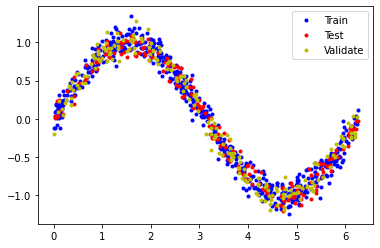

In [ ]:
# We'll use 60% of our data for training and 20% for testing. The remaining 20%
# will be used for validation. Calculate the indices of each section.
TRAIN_SPLIT =  int(0.6 * SAMPLES)
TEST_SPLIT = int(0.2 * SAMPLES + TRAIN_SPLIT)

# Use np.split to chop our data into three parts.
# The second argument to np.split is an array of indices where the data will be
# split. We provide two indices, so the data will be divided into three chunks.
x_train, x_test, x_validate = np.split(x_values, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_test, y_validate = np.split(y_values, [TRAIN_SPLIT, TEST_SPLIT])

# Double check that our splits add up correctly
assert (x_train.size + x_validate.size + x_test.size) ==  SAMPLES

# Plot the data in each partition in different colors:
plt.plot(x_train, y_train, 'b.', label="Train")
plt.plot(x_test, y_test, 'r.', label="Test")
plt.plot(x_validate, y_validate, 'y.', label="Validate")
plt.legend()
plt.show()


# LSTM

## Design the Model

In [ ]:
model = tf.keras.Sequential()

# First layer takes a scalar input and feeds it through 16 "neurons". The
# neurons decide whether to activate based on the 'relu' activation function.
model.add(keras.layers.LSTM(units=100, activation="relu", input_shape=(1,1,)))

# The new second and third layer will help the network learn more complex representations
model.add(keras.layers.Dense(100, activation='relu'))

# Final layer is a single neuron, since we want to output a single value
model.add(keras.layers.Dense(1))

# Compile the model using the standard 'adam' optimizer and the mean squared error or 'mse' loss function for regression.
model.compile(optimizer='adam', loss="mse", metrics=["mae"])

# Train the Model

## Train the Model

In [ ]:
x_train_reshape = x_train.reshape((x_train.shape[0],1, 1))
x_validate_reshape = x_validate.reshape((x_validate.shape[0], 1, 1))

history = model.fit(x_train_reshape, y_train, epochs=500, batch_size=64, validation_data=(x_validate_reshape, y_validate))

model.save(MODEL_TF)

model.save(MODEL_H5)

Epoch 1/500
10/10 [==============================] - 2s 43ms/step - loss: 0.4883 - mae: 0.6199 - val_loss: 0.4420 - val_mae: 0.5813
Epoch 2/500
10/10 [==============================] - 0s 10ms/step - loss: 0.4124 - mae: 0.5561 - val_loss: 0.3868 - val_mae: 0.5407
Epoch 3/500
10/10 [==============================] - 0s 10ms/step - loss: 0.3513 - mae: 0.5068 - val_loss: 0.3414 - val_mae: 0.5098
Epoch 4/500
10/10 [==============================] - 0s 8ms/step - loss: 0.3290 - mae: 0.4904 - val_loss: 0.3019 - val_mae: 0.4824
Epoch 5/500
10/10 [==============================] - 0s 7ms/step - loss: 0.2780 - mae: 0.4521 - val_loss: 0.2661 - val_mae: 0.4560
Epoch 6/500
10/10 [==============================] - 0s 7ms/step - loss: 0.2378 - mae: 0.4214 - val_loss: 0.2357 - val_mae: 0.4319
Epoch 7/500
10/10 [==============================] - 0s 7ms/step - loss: 0.2155 - mae: 0.4035 - val_loss: 0.2111 - val_mae: 0.4076
Epoch 8/500
10/10 [==============================] - 0s 8ms/step - loss: 0.1856 

INFO:tensorflow:Assets written to: models/model/assets


## Plot Metrics

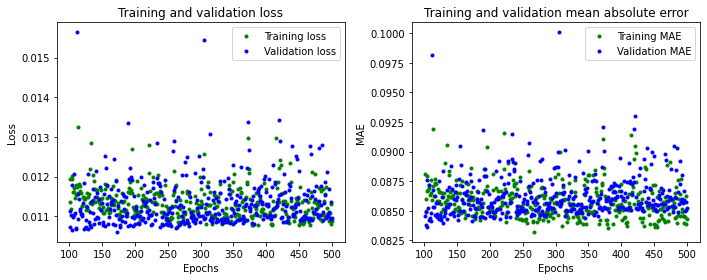

In [ ]:
# Draw a graph of the loss, which is the distance between
# the predicted and actual values during training and validation.
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

# Exclude the first few epochs so the graph is easier to read
SKIP = 100

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)

plt.plot(epochs[SKIP:], train_loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)

# Draw a graph of mean absolute error, which is another way of
# measuring the amount of error in the prediction.
train_mae = history.history['mae']
val_mae = history.history['val_mae']

plt.plot(epochs[SKIP:], train_mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()

7/7 [==============================] - 0s 2ms/step - loss: 0.0102 - mae: 0.0802


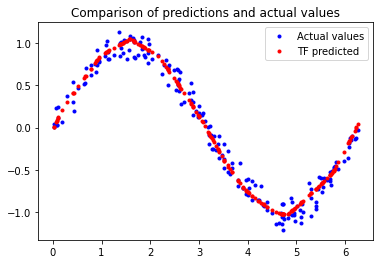

In [ ]:
x_test_reshape = x_test.reshape((x_test.shape[0],1, 1))


# Calculate and print the loss on our test dataset
test_loss, test_mae = model.evaluate(x_test_reshape, y_test)

# Make predictions based on our test dataset
y_test_pred = model.predict(x_test_reshape)

# Graph the predictions against the actual values
plt.clf()
plt.title('Comparison of predictions and actual values')
plt.plot(x_test, y_test, 'b.', label='Actual values')
plt.plot(x_test, y_test_pred, 'r.', label='TF predicted')
plt.legend()
plt.show()

# Generate a TensorFlow Lite Model

In [ ]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
model_no_quant_tflite = converter.convert()

# Save the model to disk
open(MODEL_NO_QUANT_TFLITE, "wb").write(model_no_quant_tflite)

# Convert the model to the TensorFlow Lite format with quantization
def representative_dataset():
  for i in range(500):
    yield([x_train[i].reshape(1, 1)])
# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce integer only quantization
#converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
#converter.inference_input_type = tf.int8
#converter.inference_output_type = tf.int8
# Provide a representative dataset to ensure we quantize correctly.
#converter.representative_dataset = representative_dataset
model_tflite = converter.convert()

# Save the model to disk
open(MODEL_TFLITE, "wb").write(model_tflite)

INFO:tensorflow:Assets written to: /tmp/tmpbkn39iv_/assets


INFO:tensorflow:Assets written to: /tmp/tmpbkn39iv_/assets


INFO:tensorflow:Assets written to: /tmp/tmp5pub3enm/assets


INFO:tensorflow:Assets written to: /tmp/tmp5pub3enm/assets


67392

# Generate a TensorFlow Lite for Microcontrollers Model

In [ ]:
# Install xxd if it is not available
!apt-get update && apt-get -qq install xxd
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
# Update variable names
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Get:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release [564 B]
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release.gpg [833 B]
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
